# Using Sum instead

Prepare data for clustering 

In [58]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan 
from sklearn.cluster import DBSCAN

In [59]:
# read data from csv file
fake_transaction = pd.read_csv('fake_transactional_data_24.csv')

In [60]:
fake_transaction.head()

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025


Generate summary statistics

In [61]:
fake_transaction.describe()

,from_totally_fake_account,monopoly_money_amount
count,1.014828e+07,1.014828e+07
mean,5.080502e+04,1.839348e+01
std,2.893710e+04,8.612323e+01
min,1.000000e+03,1.450000e+00
25%,2.530400e+04,2.650000e+00
50%,5.078100e+04,6.000000e+00
75%,7.563300e+04,1.200000e+01
max,1.009880e+05,1.995000e+03


In [62]:
fake_transaction.columns

Index(['from_totally_fake_account', 'monopoly_money_amount',
       'to_randomly_generated_account', 'not_happened_yet_date'],
      dtype='object')

count Null values

In [63]:
nanCount = fake_transaction.isnull().sum()
nanCount


from_totally_fake_account        0
monopoly_money_amount            0
to_randomly_generated_account    0
not_happened_yet_date            0
dtype: int64

Check correlation of features

In [64]:
from scipy.stats import pearsonr

# Selecting only numeric columns
numeric_columns = fake_transaction.select_dtypes(include=[np.number]).columns

# Creating an empty DataFrame for the correlation matrix
correlationMatrix = pd.DataFrame(index=numeric_columns, columns=numeric_columns)

# Calculating Pearson correlation coefficient for each pair of columns
for i in numeric_columns:
    for j in numeric_columns:
        correlationMatrix.loc[i, j] = np.round(pearsonr(fake_transaction[i], fake_transaction[j])[0], 2)
print(correlationMatrix)


                          from_totally_fake_account monopoly_money_amount
from_totally_fake_account                       1.0                   0.0
monopoly_money_amount                           0.0                   1.0


both correlation coefficients are 0 between the 2 variables, so there is no linear relationship between them

## Identify non-numerical values by feature

In [65]:
fake_transaction

,from_totally_fake_account,monopoly_money_amount,to_randomly_generated_account,not_happened_yet_date
0,10371.0,4.00,CINEMA,01/01/2025
1,88339.0,2.40,40544,01/01/2025
2,18555.0,2.40,85149,01/01/2025
3,18555.0,4.10,HIPSTER_COFFEE_SHOP,01/01/2025
4,80792.0,1.95,18555,01/01/2025
...,...,...,...,...
10148275,32185.0,2.65,COFFEE_SHOP,31/12/2025
10148276,32185.0,2.45,COFFEE_SHOP,31/12/2025
10148277,57569.0,14.00,WINE_BAR,31/12/2025
10148278,1490.0,9.00,57569,31/12/2025


In [66]:
for i, val in enumerate(fake_transaction['to_randomly_generated_account']):
    # check value is numeric?
    if str(val).isnumeric():
        # replace numeric with NaN
        fake_transaction.at[i, 'to_randomly_generated_account'] = pd.NA

# drop rows where 'to_randomly_generated_account' is NaN
fake_transaction.dropna(subset=['to_randomly_generated_account'], inplace=True)

fake_transaction.reset_index(drop=True, inplace=True)

# show only people spend on business account
print(fake_transaction)

         from_totally_fake_account  monopoly_money_amount  \
0                          10371.0                   4.00   
1                          18555.0                   4.10   
2                          18555.0                   4.45   
3                          18555.0                   1.45   
4                          18555.0                   5.00   
...                            ...                    ...   
7615512                    81404.0                   1.80   
7615513                    32185.0                   2.65   
7615514                    32185.0                   2.45   
7615515                    57569.0                  14.00   
7615516                    53444.0                   2.65   

        to_randomly_generated_account not_happened_yet_date  
0                              CINEMA            01/01/2025  
1                 HIPSTER_COFFEE_SHOP            01/01/2025  
2          TOTALLY_A_REAL_COFFEE_SHOP            01/01/2025  
3                  

# Feature 1 using All business

In [67]:
feature_1 = fake_transaction.pivot_table(index='from_totally_fake_account',
                                columns='to_randomly_generated_account',
                                values='monopoly_money_amount',
                                aggfunc='sum')
#feature_1.reset_index(drop=True, inplace=True)
feature_1.reset_index(inplace=True)

feature_1

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,NaN,278.15,269.25,217.86,850.5,NaN,NaN,NaN,19.5,...,NaN,55.00,NaN,NaN,52.0,13.18,459.0,NaN,550.0,104.98
1,1002.0,NaN,123.40,109.40,483.98,1284.0,NaN,NaN,NaN,5.0,...,NaN,NaN,113.0,NaN,289.0,41.36,36.5,49.99,NaN,104.98
2,1006.0,NaN,278.40,318.85,333.19,1206.5,NaN,1266.98,218.0,11.0,...,389.0,NaN,NaN,NaN,342.0,NaN,27.0,28.98,NaN,49.99
3,1018.0,NaN,NaN,8.15,284.91,783.0,NaN,990.00,26.0,11.0,...,NaN,NaN,NaN,NaN,NaN,14.09,21.0,29.99,33.0,10.00
4,1053.0,NaN,123.50,140.50,280.10,1150.0,NaN,NaN,18.0,185.5,...,NaN,83.18,NaN,NaN,129.0,10.45,84.5,29.99,131.0,74.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,100931.0,NaN,147.05,147.90,236.94,1751.0,NaN,1220.18,NaN,30.0,...,81.0,27.73,450.0,NaN,674.0,48.64,13.0,49.99,21.5,29.99
8138,100934.0,NaN,124.25,126.80,965.56,1326.5,20.0,NaN,NaN,12.5,...,NaN,15.91,NaN,NaN,NaN,NaN,153.0,84.99,100.0,NaN
8139,100947.0,NaN,160.65,121.85,1901.31,1411.5,204.0,NaN,27.0,191.0,...,NaN,21.82,90.0,NaN,24.0,NaN,70.5,19.99,193.0,8.99
8140,100986.0,NaN,6.95,2.65,593.59,1236.5,NaN,NaN,NaN,14.0,...,NaN,15.45,38.0,NaN,22.0,NaN,237.5,24.99,166.0,64.98


Some cell has NaN where people have not spent money so, I will replace these values with 0.

In [68]:
# replace NaN with 0
feature_1 = feature_1.fillna(0)
feature_1.head(10)

to_randomly_generated_account,from_totally_fake_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,1000.0,0.0,278.15,269.25,217.86,850.5,0.0,0.00,0.0,19.5,...,0.0,55.00,0.0,0.0,52.0,13.18,459.0,0.00,550.0,104.98
1,1002.0,0.0,123.40,109.40,483.98,1284.0,0.0,0.00,0.0,5.0,...,0.0,0.00,113.0,0.0,289.0,41.36,36.5,49.99,0.0,104.98
2,1006.0,0.0,278.40,318.85,333.19,1206.5,0.0,1266.98,218.0,11.0,...,389.0,0.00,0.0,0.0,342.0,0.00,27.0,28.98,0.0,49.99
3,1018.0,0.0,0.00,8.15,284.91,783.0,0.0,990.00,26.0,11.0,...,0.0,0.00,0.0,0.0,0.0,14.09,21.0,29.99,33.0,10.00
4,1053.0,0.0,123.50,140.50,280.10,1150.0,0.0,0.00,18.0,185.5,...,0.0,83.18,0.0,0.0,129.0,10.45,84.5,29.99,131.0,74.99
5,1059.0,0.0,103.45,91.95,287.09,916.5,0.0,0.00,0.0,34.5,...,205.0,68.18,0.0,0.0,215.0,23.18,0.0,10.00,0.0,0.00
6,1071.0,0.0,131.10,127.90,423.50,785.0,0.0,0.00,30.0,18.5,...,0.0,45.45,326.0,0.0,378.0,0.00,6.0,79.97,16.5,29.99
7,1078.0,0.0,156.40,128.55,1705.16,858.5,0.0,0.00,207.0,18.0,...,177.0,39.09,0.0,0.0,60.0,0.00,21.0,9.00,12.5,0.00
8,1086.0,0.0,133.30,112.30,401.88,797.5,0.0,1222.00,0.0,25.0,...,145.0,34.55,117.0,0.0,82.0,0.00,18.0,74.99,15.0,83.98
9,1087.0,0.0,345.20,312.90,0.00,748.5,20.0,0.00,0.0,10.5,...,0.0,24.55,0.0,0.0,43.0,8.18,499.5,0.00,536.0,29.99


In [69]:
# get all column names
feature_1.columns

Index(['from_totally_fake_account', 'ACCESSORY_SHOP', 'A_CAFE',
       'A_LOCAL_COFFEE_SHOP', 'A_SUPERMARKET', 'BAR', 'BOOKSHOP', 'BUTCHER',
       'BUTCHERS', 'CAFE', 'CHILDRENDS_SHOP', 'CHINESE_RESTAURANT',
       'CHINESE_TAKEAWAY', 'CINEMA', 'CLOTHES_SHOP', 'COCKTAIL_BAR',
       'COFFEE_SHOP', 'COMIC_BOOK_SHOP', 'COOKSHOP', 'DEPARTMENT_STORE',
       'DIY_STORE', 'DVD_SHOP', 'ELECTRONICS_SHOP', 'EXPRESS_SUPERMARKET',
       'FASHIONABLE_SPORTSWARE_SHOP', 'FASHION_SHOP', 'FLORIST', 'G&T_BAR',
       'GAME_SHOP', 'GOURMET_COFFEE_SHOP', 'GREENGROCER', 'GYM',
       'HIPSTER_COFFEE_SHOP', 'HIPSTER_ELECTRONICS_SHOP',
       'HOME_IMPROVEMENT_STORE', 'INDIAN_RESTAURANT', 'JEWLLERY_SHOP',
       'KEBAB_SHOP', 'KIDS_ACTIVITY_CENTRE', 'KIDS_CLOTHING_SHOP',
       'LARGE_SUPERMARKET', 'LIQUOR_STORE', 'LOCAL_BOOKSHOP', 'LOCAL_PUB',
       'LOCAL_RESTAURANT', 'LOCAL_WATERING_HOLE', 'LUNCH_PLACE', 'LUNCH_VAN',
       'NERDY_BOOK_STORE', 'PET_SHOP', 'PET_TOY_SHOP',
       'PRETENTIOUS_COFFEE_SH

In [70]:
# drop the 1st column because it is index value
feature_1 = feature_1.drop(columns=['from_totally_fake_account'])
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,278.15,269.25,217.86,850.5,0.0,0.00,0.0,19.5,0.0,...,0.0,55.00,0.0,0.0,52.0,13.18,459.0,0.00,550.0,104.98
1,0.0,123.40,109.40,483.98,1284.0,0.0,0.00,0.0,5.0,0.0,...,0.0,0.00,113.0,0.0,289.0,41.36,36.5,49.99,0.0,104.98
2,0.0,278.40,318.85,333.19,1206.5,0.0,1266.98,218.0,11.0,0.0,...,389.0,0.00,0.0,0.0,342.0,0.00,27.0,28.98,0.0,49.99
3,0.0,0.00,8.15,284.91,783.0,0.0,990.00,26.0,11.0,59.0,...,0.0,0.00,0.0,0.0,0.0,14.09,21.0,29.99,33.0,10.00
4,0.0,123.50,140.50,280.10,1150.0,0.0,0.00,18.0,185.5,20.0,...,0.0,83.18,0.0,0.0,129.0,10.45,84.5,29.99,131.0,74.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,147.05,147.90,236.94,1751.0,0.0,1220.18,0.0,30.0,0.0,...,81.0,27.73,450.0,0.0,674.0,48.64,13.0,49.99,21.5,29.99
8138,0.0,124.25,126.80,965.56,1326.5,20.0,0.00,0.0,12.5,0.0,...,0.0,15.91,0.0,0.0,0.0,0.00,153.0,84.99,100.0,0.00
8139,0.0,160.65,121.85,1901.31,1411.5,204.0,0.00,27.0,191.0,78.0,...,0.0,21.82,90.0,0.0,24.0,0.00,70.5,19.99,193.0,8.99
8140,0.0,6.95,2.65,593.59,1236.5,0.0,0.00,0.0,14.0,0.0,...,0.0,15.45,38.0,0.0,22.0,0.00,237.5,24.99,166.0,64.98


In [71]:
# find the number of row and column
feature_1.shape

(8142, 79)

We have 79 column (from 79 businesses)

In [72]:
# get some statistic values from dataset
feature_1.describe()

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
count,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,...,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000,8142.000000
mean,9.194547,140.596199,140.252063,694.273960,1038.821113,39.858757,257.614284,36.159175,60.089106,112.514738,...,111.806313,29.037582,36.045566,12.070744,94.621960,29.157294,167.493859,28.814226,166.198907,28.560581
std,45.037107,96.217462,95.702481,520.606841,282.728111,75.975948,485.956277,59.181030,87.719505,172.885410,...,171.118617,32.330643,98.722812,24.260434,120.884081,32.262728,196.091028,36.575284,193.925706,36.839079
min,0.000000,0.000000,0.000000,0.000000,239.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,103.350000,102.650000,274.677500,840.500000,0.000000,0.000000,0.000000,9.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.500000,0.000000,22.000000,0.000000
50%,0.000000,130.100000,129.375000,493.225000,1037.500000,0.000000,0.000000,0.000000,19.000000,0.000000,...,0.000000,21.360000,0.000000,0.000000,43.000000,21.820000,72.000000,12.000000,71.000000,12.000000
75%,0.000000,167.250000,167.325000,1079.122500,1222.375000,20.000000,0.000000,55.000000,38.500000,193.000000,...,191.000000,46.370000,0.000000,0.000000,157.000000,46.360000,323.500000,49.980000,319.000000,47.970000
max,479.000000,377.250000,368.700000,2761.520000,2781.500000,375.000000,1652.320000,367.000000,384.500000,1010.000000,...,963.000000,261.380000,766.000000,75.000000,681.000000,238.180000,869.500000,284.960000,1005.500000,283.950000


In [73]:
feature_1

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,278.15,269.25,217.86,850.5,0.0,0.00,0.0,19.5,0.0,...,0.0,55.00,0.0,0.0,52.0,13.18,459.0,0.00,550.0,104.98
1,0.0,123.40,109.40,483.98,1284.0,0.0,0.00,0.0,5.0,0.0,...,0.0,0.00,113.0,0.0,289.0,41.36,36.5,49.99,0.0,104.98
2,0.0,278.40,318.85,333.19,1206.5,0.0,1266.98,218.0,11.0,0.0,...,389.0,0.00,0.0,0.0,342.0,0.00,27.0,28.98,0.0,49.99
3,0.0,0.00,8.15,284.91,783.0,0.0,990.00,26.0,11.0,59.0,...,0.0,0.00,0.0,0.0,0.0,14.09,21.0,29.99,33.0,10.00
4,0.0,123.50,140.50,280.10,1150.0,0.0,0.00,18.0,185.5,20.0,...,0.0,83.18,0.0,0.0,129.0,10.45,84.5,29.99,131.0,74.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,147.05,147.90,236.94,1751.0,0.0,1220.18,0.0,30.0,0.0,...,81.0,27.73,450.0,0.0,674.0,48.64,13.0,49.99,21.5,29.99
8138,0.0,124.25,126.80,965.56,1326.5,20.0,0.00,0.0,12.5,0.0,...,0.0,15.91,0.0,0.0,0.0,0.00,153.0,84.99,100.0,0.00
8139,0.0,160.65,121.85,1901.31,1411.5,204.0,0.00,27.0,191.0,78.0,...,0.0,21.82,90.0,0.0,24.0,0.00,70.5,19.99,193.0,8.99
8140,0.0,6.95,2.65,593.59,1236.5,0.0,0.00,0.0,14.0,0.0,...,0.0,15.45,38.0,0.0,22.0,0.00,237.5,24.99,166.0,64.98


## Kmean

In [74]:
# split the data
X_train, X_test = train_test_split(feature_1, test_size=0.2, random_state=42)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

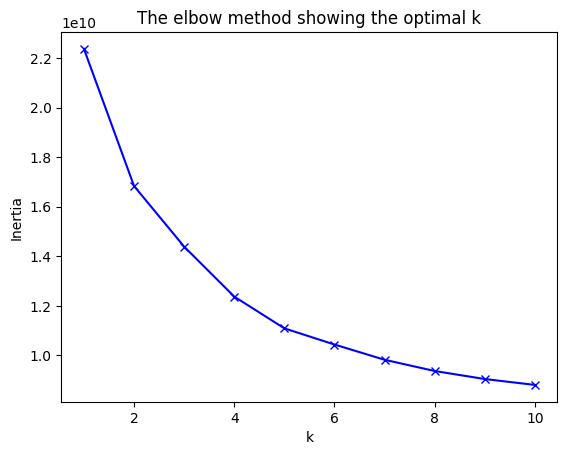

In [75]:
# loop over values of k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class with k clusters
    kmeans = KMeans(n_clusters= k)
    
    # fit the model to the data
    kmeans.fit(X_train)

    # store the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [76]:
# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train)

# predict clusters for the test data
test_clusters = kmeans.predict(X_train)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.21195661197162693


## HDBSCAN

Silhouette Score: 0.09547844573705255
Number of clusters identified: 3


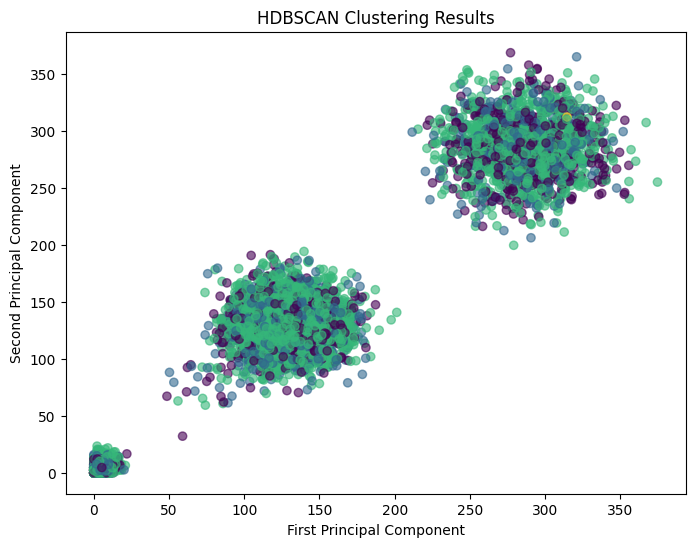

In [77]:
# initialize HDBSCAN with default parameters --> I will try to do more with changing parameter
clusterer = hdbscan.HDBSCAN()

# fit he model
clusterer.fit(X_train)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_train)

# evaluate the clusters
silhouette_avg = silhouette_score(X_train, test_clusters)
print("Silhouette Score:", silhouette_avg)

num_clusters = len(np.unique(clusterer.labels_)) - 1  # -1 because I want to exclude noise points
print("Number of clusters identified:", num_clusters)

plt.figure(figsize=(8, 6))
plt.scatter(X_train.iloc[:, 1], X_train.iloc[:, 2], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()



## DBSCAN

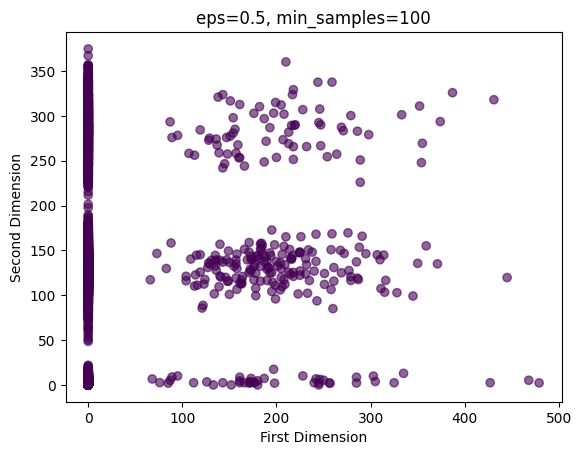

In [78]:
dbscan = DBSCAN(eps=0.5, min_samples=100)
test_clusters = dbscan.fit_predict(X_train)


plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title(f"eps=0.5, min_samples=100")
plt.xlabel("First Dimension")
plt.ylabel("Second Dimension")

plt.show()


In [79]:
# only one class so i cannot find the Silhouette Score

# Feature 2 with all business but with PCA

In [80]:
feature_2 = feature_1
feature_2

to_randomly_generated_account,ACCESSORY_SHOP,A_CAFE,A_LOCAL_COFFEE_SHOP,A_SUPERMARKET,BAR,BOOKSHOP,BUTCHER,BUTCHERS,CAFE,CHILDRENDS_SHOP,...,TOY_SHOP,TO_BEAN_OR_NOT_TO_BEAN,TRAINER_SHOP,TURKEY_FARM,VIDEO_GAME_STORE,WE_HAVE_BEAN_WEIGHTING,WHISKEY_BAR,WHISKEY_SHOP,WINE_BAR,WINE_CELLAR
0,0.0,278.15,269.25,217.86,850.5,0.0,0.00,0.0,19.5,0.0,...,0.0,55.00,0.0,0.0,52.0,13.18,459.0,0.00,550.0,104.98
1,0.0,123.40,109.40,483.98,1284.0,0.0,0.00,0.0,5.0,0.0,...,0.0,0.00,113.0,0.0,289.0,41.36,36.5,49.99,0.0,104.98
2,0.0,278.40,318.85,333.19,1206.5,0.0,1266.98,218.0,11.0,0.0,...,389.0,0.00,0.0,0.0,342.0,0.00,27.0,28.98,0.0,49.99
3,0.0,0.00,8.15,284.91,783.0,0.0,990.00,26.0,11.0,59.0,...,0.0,0.00,0.0,0.0,0.0,14.09,21.0,29.99,33.0,10.00
4,0.0,123.50,140.50,280.10,1150.0,0.0,0.00,18.0,185.5,20.0,...,0.0,83.18,0.0,0.0,129.0,10.45,84.5,29.99,131.0,74.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8137,0.0,147.05,147.90,236.94,1751.0,0.0,1220.18,0.0,30.0,0.0,...,81.0,27.73,450.0,0.0,674.0,48.64,13.0,49.99,21.5,29.99
8138,0.0,124.25,126.80,965.56,1326.5,20.0,0.00,0.0,12.5,0.0,...,0.0,15.91,0.0,0.0,0.0,0.00,153.0,84.99,100.0,0.00
8139,0.0,160.65,121.85,1901.31,1411.5,204.0,0.00,27.0,191.0,78.0,...,0.0,21.82,90.0,0.0,24.0,0.00,70.5,19.99,193.0,8.99
8140,0.0,6.95,2.65,593.59,1236.5,0.0,0.00,0.0,14.0,0.0,...,0.0,15.45,38.0,0.0,22.0,0.00,237.5,24.99,166.0,64.98


## Principal Component Analysis

I will projects the data from the original 79-dimensional space to lower dimensional space.

In [81]:
n_components = 79
whiten = False # transformed data = scale as the original data
random_state = 10

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

In [82]:
X_train, X_test = train_test_split(feature_2, test_size=0.2, random_state=42)


In [83]:
X_train_PCA = pca.fit_transform(X_train)
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,198.961678,-625.577625,-760.152716,-525.051450,588.964080,-125.613021,-55.485366,-72.482826,-24.459620,-427.863642,...,22.564522,-4.508314,14.975682,5.955936,-8.957039,-4.506953,2.841695,1.196864,3.702556,-0.277143
1,1534.897102,-551.996246,412.752062,495.680545,-216.345589,-7.113824,511.584123,-128.134755,50.821346,-550.322544,...,10.781015,-8.487927,-20.884576,13.103442,7.678962,1.433795,-8.310443,-10.382917,-2.693573,-0.020947
2,1602.010696,1204.827712,-821.987806,124.549477,-154.507983,-315.498498,-91.662997,51.851283,104.599247,209.481621,...,-2.310346,72.952097,2.625953,22.685956,-38.657001,2.022463,-2.120993,5.641789,-1.865748,-0.109574
3,-1326.140387,-307.250805,569.717960,862.230174,-250.962425,-66.066987,-86.196256,-20.179957,21.259874,136.670683,...,21.149450,-8.408788,-4.878025,-11.845359,11.156177,-3.086759,-2.723973,6.642129,4.048202,0.011714
4,-1120.877668,1713.153982,-1020.168769,418.473035,-196.090834,79.627622,-199.769060,-7.910781,87.089812,-132.004530,...,10.932755,4.078335,3.316234,-0.244523,5.344716,0.760056,-2.499891,-1.468529,1.503455,-0.465416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6508,1559.573755,-779.883951,-48.375046,416.121454,430.746189,-115.138178,93.334847,-820.121503,-856.784284,312.943220,...,-8.553124,-10.806963,6.071468,-6.472667,11.787050,-1.352451,-0.141604,-0.953925,0.721814,-1.127457
6509,-119.588644,-594.905350,508.283428,-371.390105,-206.847711,935.379947,553.714424,-374.822564,10.211512,-160.167874,...,4.574916,42.732872,3.126957,-14.327656,-1.366951,-0.496954,-10.948369,-11.265481,-0.535724,-0.430436
6510,804.021469,-504.773360,-1004.719559,-261.176406,663.538100,-284.903181,-11.816346,-454.587291,183.198619,-285.720051,...,8.777091,19.422305,14.100534,0.232777,16.345343,41.438523,3.210898,2.970079,7.389747,-0.190604
6511,524.405241,-662.762976,254.438604,-72.347887,554.107577,-55.235831,-59.997468,-379.655329,241.213380,-338.487594,...,-9.967001,-6.207636,-0.399929,0.672397,9.354098,-1.028674,4.001915,2.177797,18.447772,-0.152209


In [84]:
# percentage of Variance Captured by 79 principal components
print("Variance Explained by all 79 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 79 principal components:  0.9999999999999998


it retaining all the information present in the original data

In [85]:
# percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 10 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:9].sum(axis=1).values)
print('Variance Captured by First 20 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:19].sum(axis=1).values)
print('Variance Captured by First 30 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:29].sum(axis=1).values)
print('Variance Captured by First 40 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:40].sum(axis=1).values)
print('Variance Captured by First 50 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:49].sum(axis=1).values)


Variance Captured by First 10 Principal Components:  [0.83740927]
Variance Captured by First 20 Principal Components:  [0.93956254]
Variance Captured by First 30 Principal Components:  [0.96952768]
Variance Captured by First 40 Principal Components:  [0.98817904]
Variance Captured by First 50 Principal Components:  [0.9948779]


The first 10 components in total capture approximately 70% of the variance, the 30th components almost 95%, the 40th components almost 98.5%, and the 50th components almost 100% of the variance.

With just the first 30th principal components (far fewer than the original 79 dimensions), we capture almost 95% of the variance/information.

In [86]:
X_test_PCA = pca.transform(X_test)
X_test_PCA.shape

(1629, 79)

## Kmean

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

Text(0.5, 1.0, 'The elbow method showing the optimal k')

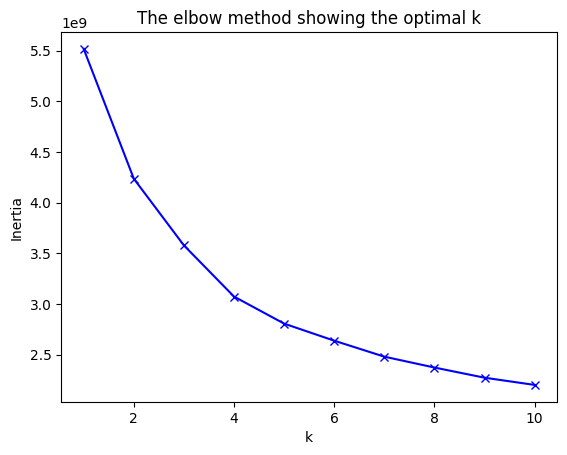

In [87]:
# fit PCA to the training data
pca = PCA(n_components=79, random_state=42)
X_train_PCA = pca.fit_transform(X_train)

# transform the test data using the same PCA object
X_test_PCA = pca.transform(X_test)

# loop over k from 1 to 10
inertias = []
K = 10
for k in range(1, K+1):
    # instantiate the KMeans class
    kmeans = KMeans(n_clusters= k)
    
    # fit the model
    kmeans.fit(X_test_PCA)

    # append the value of the inertia for this value of k
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')




In [88]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.19841889181266467


In [89]:
# apply K-means clustering to the reduced-dimensional features
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = kmeans.predict(X_test_PCA)

# evaluate the clustering performance
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.21630271183407934


## HDBSCAN

In [90]:
# initialize HDBSCAN
clusterer = hdbscan.HDBSCAN()

# fit model
clusterer.fit(X_train_PCA)

# predict clusters for the test data
test_clusters = clusterer.fit_predict(X_test_PCA)

# evaluate the clusters
silhouette_avg = silhouette_score(X_test_PCA, test_clusters)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.002282784934436751


In [91]:
# count the number of unique cluster labels
num_clusters = len(np.unique(clusterer.labels_)) - 1  # Exclude noise points (-1)
print("Number of clusters identified:", num_clusters)


Number of clusters identified: 8


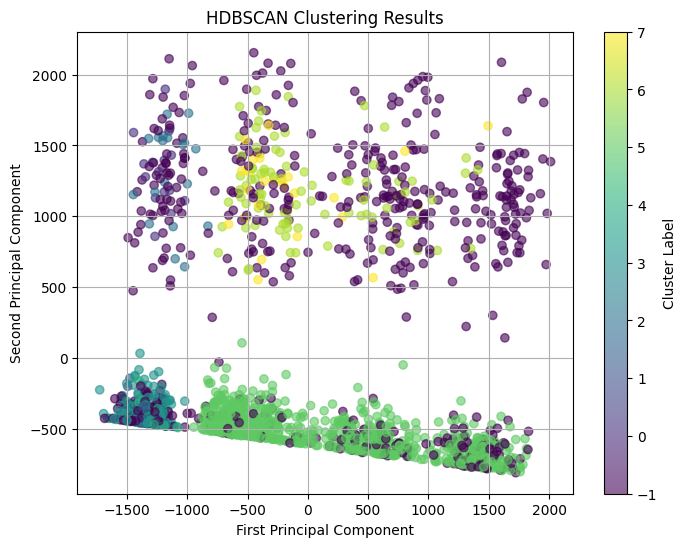

In [92]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
plt.title("HDBSCAN Clustering Results")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()


## DBSCAN

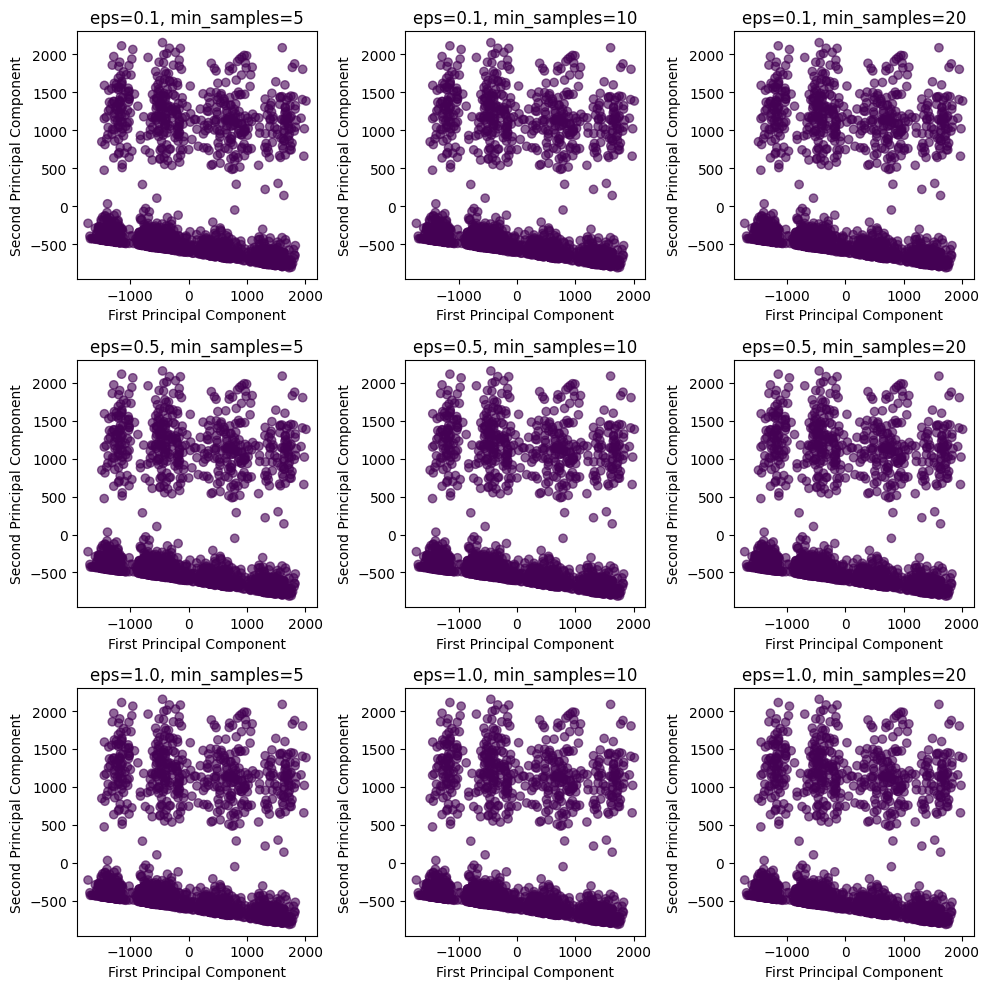

In [95]:
# initialize DBSCAN with different parameters
eps_values = [0.1, 0.5, 1.0]
min_samples_values = [5, 10, 20]

fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(10, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # fit DBSCAN to the reduced-dimensional features
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        test_clusters = dbscan.fit_predict(X_test_PCA)

        axs[i, j].scatter(X_test_PCA[:, 0], X_test_PCA[:, 1], c=test_clusters, cmap='viridis', alpha=0.6)
        axs[i, j].set_title(f"eps={eps}, min_samples={min_samples}")
        axs[i, j].set_xlabel("First Principal Component")
        axs[i, j].set_ylabel("Second Principal Component")

plt.tight_layout()
plt.show()
